# Лабораторная работа №4

*Соловьев Роман, Халилов Роман М32001*

## Методы решения СЛАУ:

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time 
from tqdm import tqdm
import prettytable
from prettytable import PrettyTable
from datetime import datetime

warnings.filterwarnings('ignore')
max_iter = 1000
eps = 0.0001

### Метод Гаусса с выбором ведущего элемента:

In [27]:
def bubble_max_row(A, F, k):
    ind = k + np.argmax(np.abs(A[k:, k]))
    if ind != k:
        A[k, :], A[ind, :] = np.copy(A[ind, :]), np.copy(A[k, :])
        F[k], F[ind] = np.copy(F[ind]), np.copy(F[k])

def gauss(A, F):
    n = A.shape[0]

    for k in range(n - 1):
        bubble_max_row(A, F, k)
        for i in range(k + 1, n):
            frac = A[i, k] / A[k, k]
            A[i, :] -= A[k, :] * frac
            F[i] -= F[k] * frac

    return A, F

def is_singular(A):
    return np.any(np.diag(A) == 0)

def solve_with_gauss(A, F):
    A, F = gauss(A, F)
    n = A.shape[0]

    if is_singular(A):
        return "Любое"

    x = np.matrix([0.0 for i in range(n)]).T
    for k in range(n - 1, -1, -1):
        x[k, 0] = (F[k] - A[k, k:n] * x[k:n, 0]) / A[k, k]

    return x

### Метод с использованием LU разложением:

#### LU разложение:

In [28]:
def decompose_to_LU(A):
    lu_matrix = np.matrix(np.zeros([A.shape[0], A.shape[1]]))
    n = A.shape[0]

    for k in range(n):
        for j in range(k, n):
            lu_matrix[k, j] = A[k, j] - lu_matrix[k, :k] * lu_matrix[:k, j]

        for i in range(k + 1, n):
            lu_matrix[i, k] = (A[i, k] - lu_matrix[i, : k] * lu_matrix[: k, k]) / lu_matrix[k, k]

    return lu_matrix

def get_L(A):
    L = A.copy()
    for i in range(L.shape[0]):
            L[i, i] = 1
            L[i, i+1 :] = 0
    return np.matrix(L)


def get_U(A):
    U = A.copy()
    for i in range(1, U.shape[0]):
        U[i, :i] = 0
    return U

#### Сам метод:

In [29]:
def solve_with_LU(A, F):
    mLU = decompose_to_LU(A)

    y = np.matrix(np.zeros([mLU.shape[0], 1]))
    for i in range(y.shape[0]):
        y[i] = F[i] - mLU[i, :i] * y[:i]

    if min(abs(y)) == 0:
        return "Любое"

    x = np.matrix(np.zeros([mLU.shape[0], 1]))
    for i in range(1, x.shape[0] + 1):
        x[-i] = (y[-i] - mLU[-i, -i:] * x[-i:] )/ mLU[-i, -i]

    return x

### Метод Якоби:

In [30]:
def create_D_and_R_matrix(A):
    n = A.shape[0]
    D = np.zeros((n, n))
    R = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                D[i][j] = 1/A[i][j]
            else:
                R[i][j] = A[i][j]
    return D, R, n

def solve_with_Jakobi(A, F, max_iter, eps):
    if is_singular(A):
        return "Матрица с 0 на главной диагонали"
    D, R, n = create_D_and_R_matrix(A)
    T = -D.dot(R)
    c = np.matrix(D.dot(F))
    x = np.matrix([0.0 for i in range(n)]).T
    for i in range(max_iter):
        x_new = T.dot(x) + c
        if np.linalg.norm(x_new - x) < eps:
            break
        x = x_new
        if i == max_iter-1:
            return "не сошлось"
    
    return x

## Генераторы матриц

### Тестовая матрица

In [31]:
def matrix_test():
    return np.array([[1., 2., 3.], 
                   [2., 3., 4.], 
                   [1., 5., 4.]])

def f_test():
    return np.array([5., 6., 7.])

In [32]:
print(solve_with_gauss(matrix_test(), f_test()))

[[-1.]
 [ 0.]
 [ 2.]]


In [33]:
print(solve_with_LU(matrix_test(), f_test()))

[[-1.]
 [-0.]
 [ 2.]]


In [34]:
print(solve_with_Jakobi(matrix_test(), f_test(), max_iter, eps))

не сошлось


### Генератор свободных коэф-в:

In [35]:
def f_gen(A):
    n = A.shape[0]
    return A * np.matrix(np.array(np.arange(1., n+1, 1))).T

### Матрицы с диагональным преобладанием

In [36]:
def diag_gen(n, k):
    A = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                A[i][j] = np.random.choice([0,-1,-2,-3,-4])
    
    for i in range(n):
        A[i][i] = -np.sum(A[:][i]) + 10**-k

    return A

### Матрицы Гилберта

In [37]:
def Gilb_gen(n):
    A = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
                A[i][j] = 1/(i+j+1)

    return A

## Сравнения методов

### Число обусловленности от k для матриц с диагональным преобладанием:

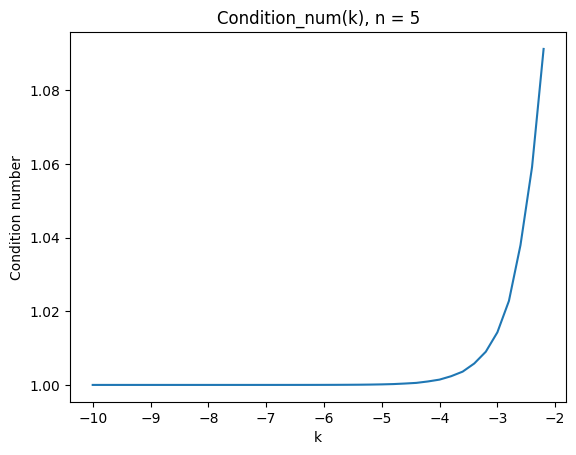

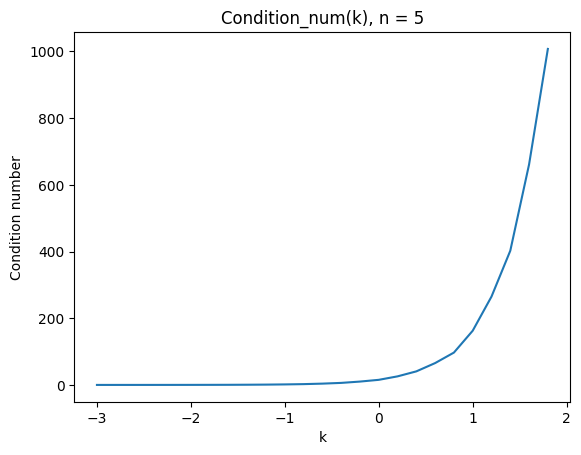

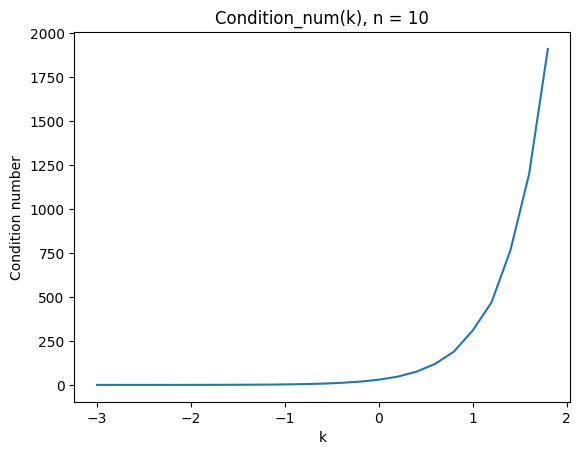

In [38]:
Condition_k = []

for k in range(-100, -20, 2):
    sum = 0
    for i in range(50):
        A = diag_gen(5, k/10)
        sum += np.linalg.cond(A)
    Condition_k.append(sum/50)
    
plt.plot(np.arange(-10., -2., 0.2), Condition_k)
plt.title("Condition_num(k), n = 5")
plt.xlabel("k")
plt.ylabel("Condition number")
plt.show()

Condition_k = []

for k in range(-30, 20, 2):
    sum = 0
    for i in range(50):
        A = diag_gen(5, k/10)
        sum += np.linalg.cond(A)
    Condition_k.append(sum/50)

plt.plot(np.arange(-3., 2., 0.2), Condition_k)
plt.title("Condition_num(k), n = 5")
plt.xlabel("k")
plt.ylabel("Condition number")
plt.show()

Condition_k = []

for k in range(-30, 20, 2):
    sum = 0
    for i in range(50):
        A = diag_gen(10, k/10)
        sum += np.linalg.cond(A)
    Condition_k.append(sum/50)

plt.plot(np.arange(-3., 2., 0.2), Condition_k)
plt.title("Condition_num(k), n = 10")
plt.xlabel("k")
plt.ylabel("Condition number")
plt.show()

### Точность решения от k для матриц с диагональным преобладанием:

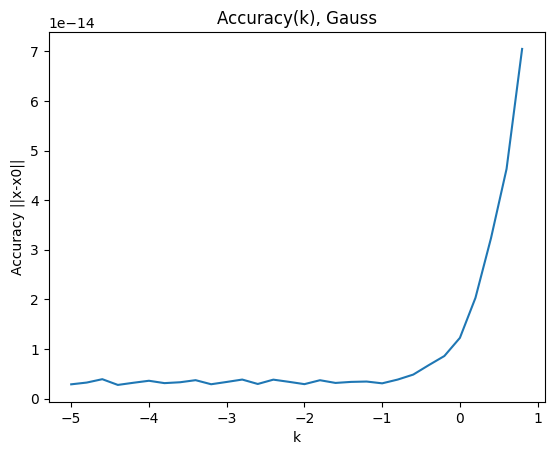

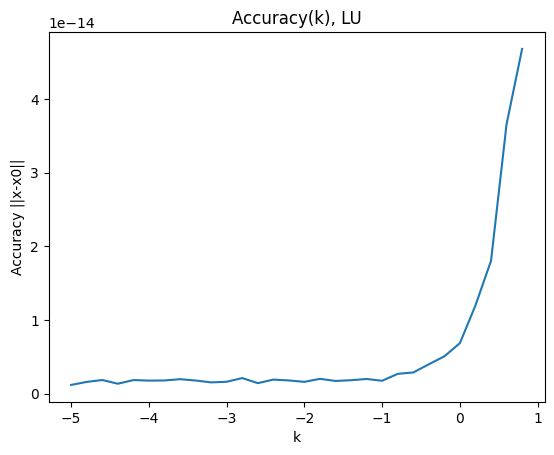

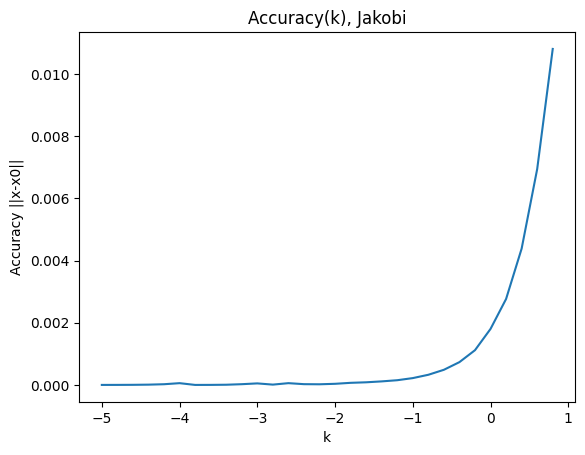

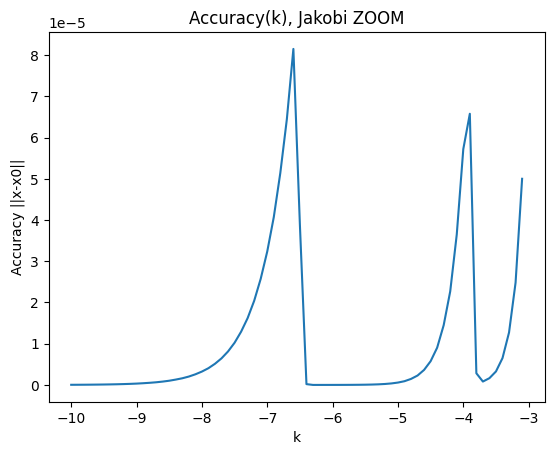

In [39]:
n = 10
x0 = np.matrix(np.array(np.arange(1., n+1, 1))).T

accuracy_k = []

for k in range(-50, 10, 2):
    sum = 0
    for i in range(50):
        A = diag_gen(n, k/10)
        F = f_gen(A)
        Solve = solve_with_gauss(A, F)
        sum += np.linalg.norm(np.abs(Solve - x0))
    accuracy_k.append(sum/50)
    
plt.plot(np.arange(-5., 1., 0.2), accuracy_k)
plt.title("Accuracy(k), Gauss")
plt.xlabel("k")
plt.ylabel("Accuracy ||x-x0||")
plt.show()

accuracy_k = []

for k in range(-50, 10, 2):
    sum = 0
    for i in range(50):
        A = diag_gen(n, k/10)
        F = f_gen(A)
        Solve = solve_with_LU(A, F)
        if Solve == "Любое":
            sum += 0
        else:
            sum += np.linalg.norm(Solve - x0)
    accuracy_k.append(sum/50)
    
plt.plot(np.arange(-5., 1., 0.2), accuracy_k)
plt.title("Accuracy(k), LU")
plt.xlabel("k")
plt.ylabel("Accuracy ||x-x0||")
plt.show()

accuracy_k = []

for k in range(-50, 10, 2):
    sum = 0
    for i in range(50):
        A = diag_gen(n, k/10)
        F = f_gen(A)
        Solve = solve_with_Jakobi(A, F, max_iter, eps)
        if Solve == "не сошлось":
            sum += 1000000000
        else:
            sum += np.linalg.norm(Solve - x0)
    accuracy_k.append(sum/50)

plt.plot(np.arange(-5., 1., 0.2), accuracy_k)
plt.title("Accuracy(k), Jakobi")
plt.xlabel("k")
plt.ylabel("Accuracy ||x-x0||")
plt.show()

accuracy_k = []

for k in range(-100, -30, 1):
    sum = 0
    for i in range(500):
        A = diag_gen(n, k/10)
        F = f_gen(A)
        Solve = solve_with_Jakobi(A, F, max_iter, eps)
        if Solve == "не сошлось":
            sum += 1000000000
        else:
            sum += np.linalg.norm(Solve - x0)
    accuracy_k.append(sum/500)

plt.plot(np.arange(-10., -3., 0.1), accuracy_k)
plt.title("Accuracy(k), Jakobi ZOOM")
plt.xlabel("k")
plt.ylabel("Accuracy ||x-x0||")
plt.show()

### Число обусловленности на матрицах Гилберта от n:

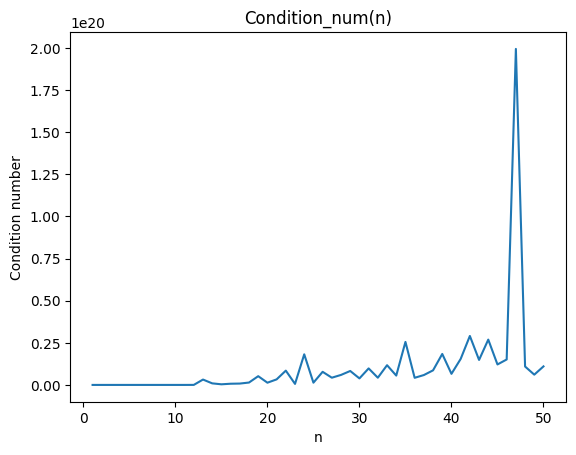

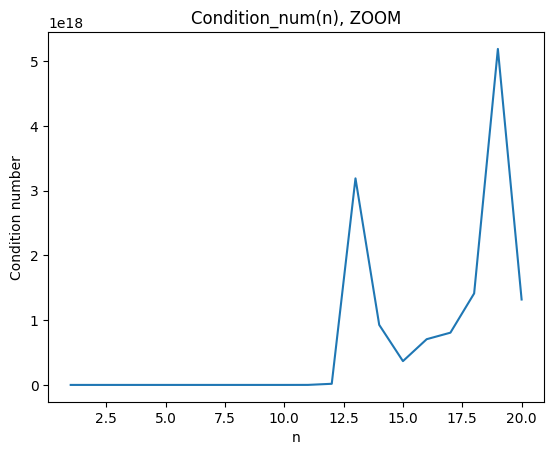

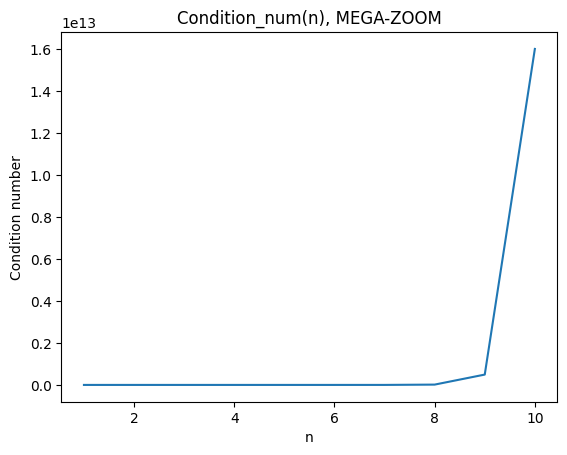

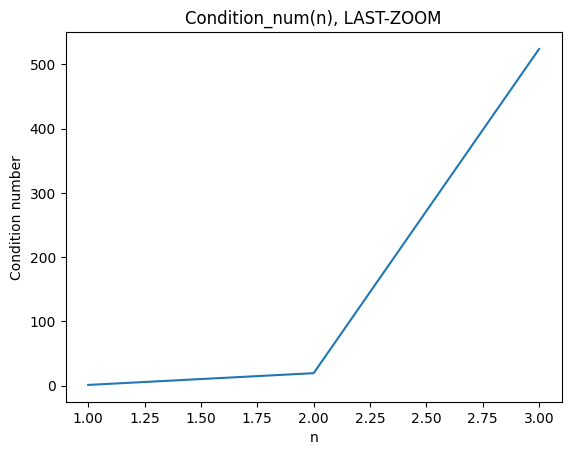

In [40]:
Condition_n = []

for n in range(1, 51, 1):
    A = Gilb_gen(n)
    sum = np.linalg.cond(A)
    Condition_n.append(sum)
    
plt.plot(np.arange(1, 51, 1), Condition_n)
plt.title("Condition_num(n)")
plt.xlabel("n")
plt.ylabel("Condition number")
plt.show()

Condition_n = []

for n in range(1, 21, 1):
    A = Gilb_gen(n)
    sum = np.linalg.cond(A)
    Condition_n.append(sum)
    
plt.plot(np.arange(1, 21, 1), Condition_n)
plt.title("Condition_num(n), ZOOM")
plt.xlabel("n")
plt.ylabel("Condition number")
plt.show()

Condition_n = []

for n in range(1, 11, 1):
    A = Gilb_gen(n)
    sum = np.linalg.cond(A)
    Condition_n.append(sum)
    
plt.plot(np.arange(1, 11, 1), Condition_n)
plt.title("Condition_num(n), MEGA-ZOOM")
plt.xlabel("n")
plt.ylabel("Condition number")
plt.show()

Condition_n = []

for n in range(1, 4, 1):
    A = Gilb_gen(n)
    sum = np.linalg.cond(A)
    Condition_n.append(sum)
    
plt.plot(np.arange(1, 4, 1), Condition_n)
plt.title("Condition_num(n), LAST-ZOOM")
plt.xlabel("n")
plt.ylabel("Condition number")
plt.show()


### Точность методов на матрицах Гилберта:

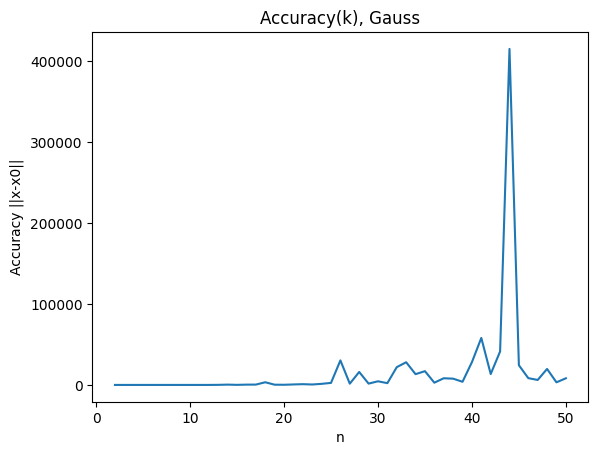

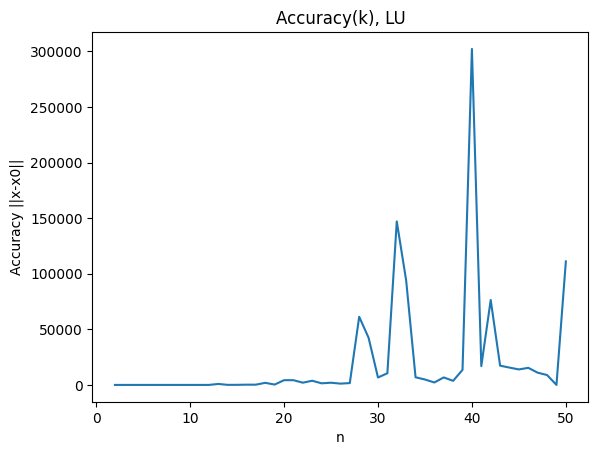

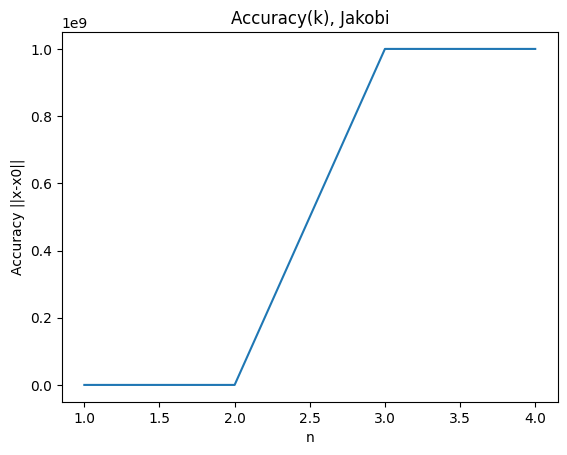

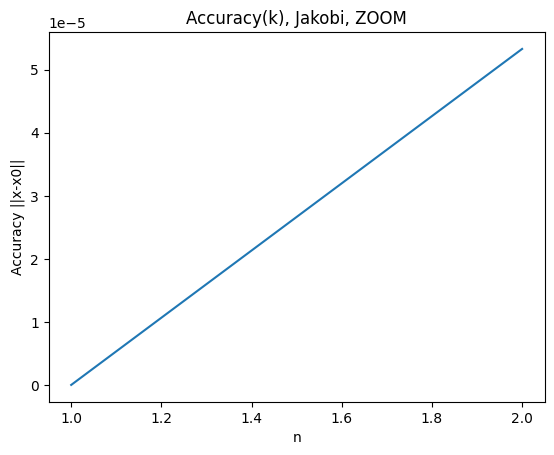

In [41]:
accuracy_n = []

for n in range(2, 51, 1):
    sum = 0
    x0 = np.matrix(np.array(np.arange(1., n+1, 1))).T
    A = Gilb_gen(n)
    F = f_gen(A)
    Solve = solve_with_gauss(A, F)
    sum += np.linalg.norm(np.abs(Solve - x0))
    accuracy_n.append(sum)
    
plt.plot(np.arange(2, 51, 1), accuracy_n)
plt.title("Accuracy(k), Gauss")
plt.xlabel("n")
plt.ylabel("Accuracy ||x-x0||")
plt.show()

accuracy_n = []

for n in range(2, 51, 1):
    sum = 0
    x0 = np.matrix(np.array(np.arange(1., n+1, 1))).T
    A = Gilb_gen(n)
    F = f_gen(A)
    Solve = solve_with_LU(A, F)
    if Solve == "Любое":
        sum += 0
    else:
        sum += np.linalg.norm(Solve - x0)
    accuracy_n.append(sum)
    
plt.plot(np.arange(2, 51, 1), accuracy_n)
plt.title("Accuracy(k), LU")
plt.xlabel("n")
plt.ylabel("Accuracy ||x-x0||")
plt.show()

accuracy_n = []

for n in range(1, 5, 1):
    sum = 0
    x0 = np.matrix(np.array(np.arange(1., n+1, 1))).T
    A = Gilb_gen(n)
    F = f_gen(A)
    Solve = solve_with_Jakobi(A, F, max_iter, eps)
    if Solve == "не сошлось":
        sum += 1000000000
    else:
        sum += np.linalg.norm(Solve - x0)
    accuracy_n.append(sum)

plt.plot(np.arange(1, 5, 1), accuracy_n)
plt.title("Accuracy(k), Jakobi")
plt.xlabel("n")
plt.ylabel("Accuracy ||x-x0||")
plt.show()

accuracy_n = []

for n in range(1, 3, 1):
    sum = 0
    x0 = np.matrix(np.array(np.arange(1., n+1, 1))).T
    A = Gilb_gen(n)
    F = f_gen(A)
    Solve = solve_with_Jakobi(A, F, max_iter, eps)
    if Solve == "не сошлось":
        sum += 1000000000
    else:
        sum += np.linalg.norm(Solve - x0)
    accuracy_n.append(sum)

plt.plot(np.arange(1, 3, 1), accuracy_n)
plt.title("Accuracy(k), Jakobi, ZOOM")
plt.xlabel("n")
plt.ylabel("Accuracy ||x-x0||")
plt.show()

### Сравнение эффективности методов от n:

In [65]:
n = [10, 50, 100, 1000, 10000]
Arr_A = []
for i in n: 
    Arr_A.append(diag_gen(i, -2))

In [74]:
eff_n_table = PrettyTable(["n", "t"])

for A in Arr_A:
    F = f_gen(A)
    start_time = datetime.now()
    ans = solve_with_gauss(A, F)
    eff_n_table.add_row([A.shape[0], (datetime.now() - start_time)])

print(eff_n_table)

+-------+----------------+
|   n   |       t        |
+-------+----------------+
|   10  | 0:00:00.001986 |
|   50  | 0:00:00.023936 |
|  100  | 0:00:00.080782 |
|  1000 | 0:00:10.053356 |
| 10000 | 0:25:10.601135 |
+-------+----------------+


In [75]:
eff_n_table = PrettyTable(["n", "t"])

for A in Arr_A:
    F = f_gen(A)
    start_time = datetime.now()
    ans = solve_with_LU(A, F)
    eff_n_table.add_row([A.shape[0], (datetime.now() - start_time)])

print(eff_n_table)

+-------+----------------+
|   n   |       t        |
+-------+----------------+
|   10  | 0:00:00.006981 |
|   50  | 0:00:00.122670 |
|  100  | 0:00:00.366018 |
|  1000 | 0:00:25.297388 |
| 10000 | 1:34:14.578968 |
+-------+----------------+


In [68]:
eff_n_table = PrettyTable(["n", "t"])

for A in Arr_A:
    F = f_gen(A)
    start_time = datetime.now()
    ans = solve_with_Jakobi(A, F, max_iter, eps)
    eff_n_table.add_row([A.shape[0], (datetime.now() - start_time)])

print(eff_n_table)

+-------+----------------+
|   n   |       t        |
+-------+----------------+
|   10  |    0:00:00     |
|   50  | 0:00:00.002001 |
|  100  | 0:00:00.007973 |
|  1000 | 0:00:00.402922 |
| 10000 | 0:01:25.079875 |
+-------+----------------+
